In [ ]:
#Importing libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import os

use_cuda = True

from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
#Google drive paths
training_set_path = "/content/gdrive/My Drive/Colab Notebooks/Project/dataset/jpegs/TrainData/"
validation_set_path = "/content/gdrive/My Drive/Colab Notebooks/Project/dataset/jpegs/ValidData/"
test_set_path = "/content/gdrive/My Drive/Colab Notebooks/Project/dataset/jpegs/TestData/"


#Loading data
transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])

training_set = torchvision.datasets.ImageFolder(training_set_path, transform=transform)
validation_set = torchvision.datasets.ImageFolder(validation_set_path, transform=transform)
test_set = torchvision.datasets.ImageFolder(test_set_path, transform=transform)

#Printing set sizes
print ("Training set size:", len(training_set))
print ("Validation set size:", len(validation_set))
print ("Testing set size:", len(test_set))


Training set size: 3892
Validation set size: 485
Testing set size: 489


In [ ]:
#Altered LargeNet code from lab 2
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "LargeNet"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10*53*53, 32) 
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10*53*53) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #Removed Squeeze
        return x

In [ ]:
#Taken from Tut_3b

#Define dataloader parameters
batch_size = 30
num_workers = 1

#Prepare data loaders
training_set_loader= torch.utils.data.DataLoader(training_set, 
                                                 batch_size=batch_size, 
                                                 num_workers=num_workers, 
                                                 shuffle=True)
validation_set_loader= torch.utils.data.DataLoader(validation_set, 
                                                   batch_size=batch_size, 
                                                   num_workers=num_workers, 
                                                   shuffle=True)
test_set_loader= torch.utils.data.DataLoader(test_set, 
                                             batch_size=batch_size, 
                                             num_workers=num_workers, 
                                             shuffle=True)

In [ ]:
#Taken from lab2 
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
# 0 = training set
# 1 = validation set
# 2 = test set 

#Modified function from Tut_3b
def get_accuracy(model, train=1):  
  if train == 0:
     data_loader = training_set_loader 
  if train == 1:
     data_loader = validation_set_loader
  if train == 2:
      data_loader = test_set_loader 

  correct = 0
  total = 0
  for imgs, labels in data_loader:
  
        #############################################
        #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
        #############################################
        
      output = model(imgs) #Changed
        
        #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
  return correct / total

In [ ]:
def train(model, batch_size=64, learning_rate=0.001, num_epochs=200):
    print("Training started: ")
    #Reshuffle Data
    train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    start_time=time.time()
    for epoch in range(num_epochs):
        #Removed mini batch code
        for imgs, labels in iter(train_loader):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            #Removed mini batch code

        # save the current training information
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train=0)) # compute training accuracy
        val_acc.append(get_accuracy(model, train=1))  # compute validation accuracy
        print(("Epoch {0}: Train acc: {1} | Train loss: {2} |  Validation acc: {3}").format(epoch, train_acc[epoch], str(float(loss)) ,val_acc[epoch]))
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

            
    end_time= time.time()

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()


    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

Training started: 
Epoch 0: Train acc: 0.10277492291880781 | Train loss: 2.3031346797943115 |  Validation acc: 0.10309278350515463
Epoch 1: Train acc: 0.09969167523124357 | Train loss: 2.2838969230651855 |  Validation acc: 0.10515463917525773
Epoch 2: Train acc: 0.0999486125385406 | Train loss: 2.3030378818511963 |  Validation acc: 0.10927835051546392
Epoch 3: Train acc: 0.13463514902363824 | Train loss: 2.270504951477051 |  Validation acc: 0.12577319587628866
Epoch 4: Train acc: 0.14311408016443988 | Train loss: 2.3422482013702393 |  Validation acc: 0.10309278350515463
Epoch 5: Train acc: 0.21891058581706063 | Train loss: 2.11505389213562 |  Validation acc: 0.16082474226804125
Epoch 6: Train acc: 0.22713257965056527 | Train loss: 2.1681981086730957 |  Validation acc: 0.2
Epoch 7: Train acc: 0.2723535457348407 | Train loss: 2.0693483352661133 |  Validation acc: 0.177319587628866
Epoch 8: Train acc: 0.2931654676258993 | Train loss: 2.190051317214966 |  Validation acc: 0.1979381443298969

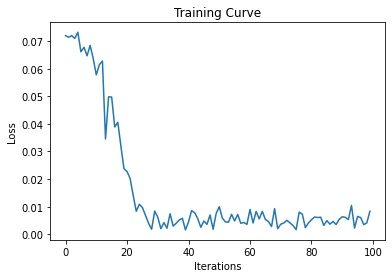

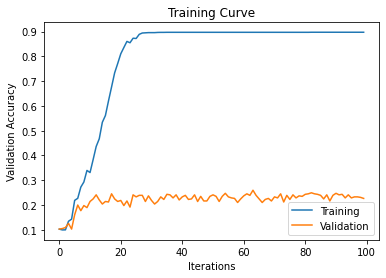

Final Training Accuracy: 0.8972250770811921
Final Validation Accuracy: 0.2268041237113402
Total time:   10056.02 s  Time per Epoch:  100.56 s 


In [8]:
model = LargeNet()
train(model, batch_size=32, learning_rate=0.004, num_epochs=100)

In [9]:
print("Test Accuracy is: ", get_accuracy(model, train=2))

Test Accuracy is:  0.2147239263803681
